Considered only building_id = 1 and meter = 0.

In [9]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LSTM, Reshape

# Define the generator model
def build_generator(latent_dim, seq_length, feature_dim):
    inputs = Input(shape=(latent_dim,))
    x = Dense(seq_length * 64, activation='relu')(inputs)
    x = Reshape((seq_length, 64))(x)  # Corrected Reshape
    x = LSTM(64, return_sequences=True)(x)
    outputs = Dense(feature_dim, activation='tanh')(x)
    model = Model(inputs, outputs, name="Generator")
    return model

# Define the discriminator model
def build_discriminator(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))
    x = LSTM(64, return_sequences=False)(inputs)
    x = Dense(1)(x)
    model = Model(inputs, x, name="Discriminator")
    return model

# Define the gradient penalty calculation
def gradient_penalty(self, real_samples, fake_samples):
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = (alpha * real_samples) + ((1 - alpha) * fake_samples)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        interpolated_output = self.discriminator(interpolated, training=True)

    grads = gp_tape.gradient(interpolated_output, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# WGAN-GP class
class WGAN_GP(Model):
    def __init__(self, generator, discriminator, latent_dim, lambda_gp):
        super(WGAN_GP, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp

    def compile(self, d_optimizer, g_optimizer):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def train_step(self, real_sequences):
        batch_size = tf.shape(real_sequences)[0]

        # Sample random noise to generate fake sequences
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_sequences = self.generator(random_latent_vectors)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(generated_sequences, training=True)
            d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
            gp = gradient_penalty(self, real_sequences, generated_sequences)
            d_loss += self.lambda_gp * gp

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train the generator
        for _ in range(5):
            with tf.GradientTape() as g_tape:
                random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
                generated_sequences = self.generator(random_latent_vectors, training=True)
                fake_output = self.discriminator(generated_sequences, training=True)
                g_loss = -tf.reduce_mean(fake_output)

            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}


# Define model parameters
latent_dim = 100
seq_length = 50  # Adjust as per your data
feature_dim = 5  # Number of features per timestamp
lambda_gp = 10

# Build and compile the models
generator = build_generator(latent_dim, seq_length, feature_dim)
discriminator = build_discriminator(seq_length, feature_dim)

# Initialize WGAN-GP model
wgan_gp = WGAN_GP(generator, discriminator, latent_dim, lambda_gp)
wgan_gp.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
)

# Define and prepare your training dataset
# Example: Random data for demonstration
import numpy as np
train_data = np.random.normal(size=(1000, seq_length, feature_dim)).astype(np.float32)
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)

# Train the model
epochs = 3000
wgan_gp.fit(train_dataset, epochs=epochs)

# Save trained generator model
generator.save('improved_generator_model.h5')

Epoch 1/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - d_loss: 8.2608 - g_loss: -0.3886
Epoch 2/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - d_loss: 7.3967 - g_loss: -0.9638
Epoch 3/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - d_loss: 5.8232 - g_loss: -1.8897
Epoch 4/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - d_loss: 4.4079 - g_loss: -2.7923
Epoch 5/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - d_loss: 3.7767 - g_loss: -2.7963
Epoch 6/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - d_loss: 3.3130 - g_loss: -2.8129
Epoch 7/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - d_loss: 2.4859 - g_loss: -2.2412
Epoch 8/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - d_loss: 1.4577 - g_loss: -1.4831
Epoch 9/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - d_loss: 0.2819 - g_loss: -0.8526
Epoch 10/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - d_loss: 1.9331 - g_loss: -2.8040
Epoch 11/3000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - d_loss: 2.3322 - g_loss: -3.2297
Epoch 12/3000
32/3

EVALUATION OF THE GAN MODEL

Real Data Statistics:
Mean: 74.86539308970856 | Std: 61.76187330675348 | Min: 0.0 | Max: 255.0

Synthetic Data Statistics:
Mean: 135.67129253266668 | Std: 38.81357310190923 | Min: 22.48702 | Max: 235.20868

KS Test Statistic: 0.4412 | P-value: 0.0000
Reject null hypothesis: Real and synthetic data distributions are significantly different.



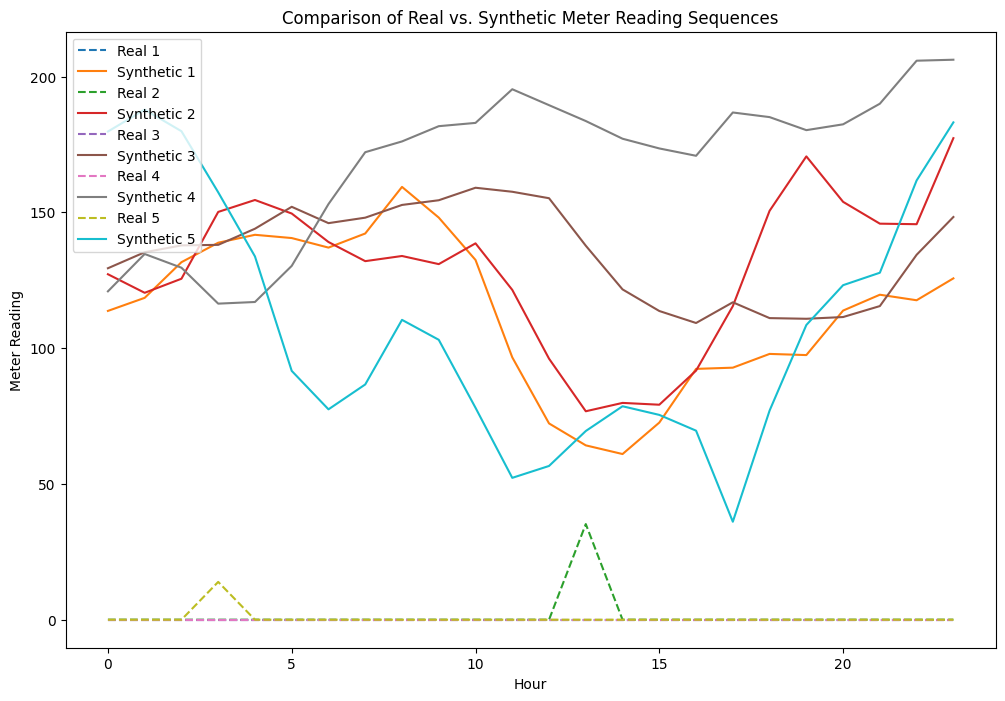

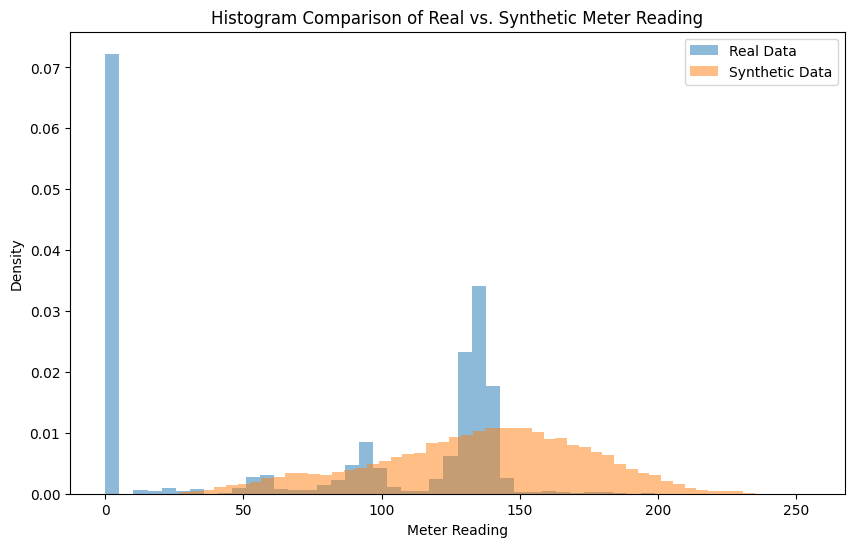

Real Data Model Evaluation:
Mean Squared Error (MSE): 34.2380
Mean Absolute Error (MAE): 2.8563
R-squared (R2): 0.9904

Synthetic Data Model Evaluation:
Mean Squared Error (MSE): 201.5620
Mean Absolute Error (MAE): 11.3846
R-squared (R2): 0.9181



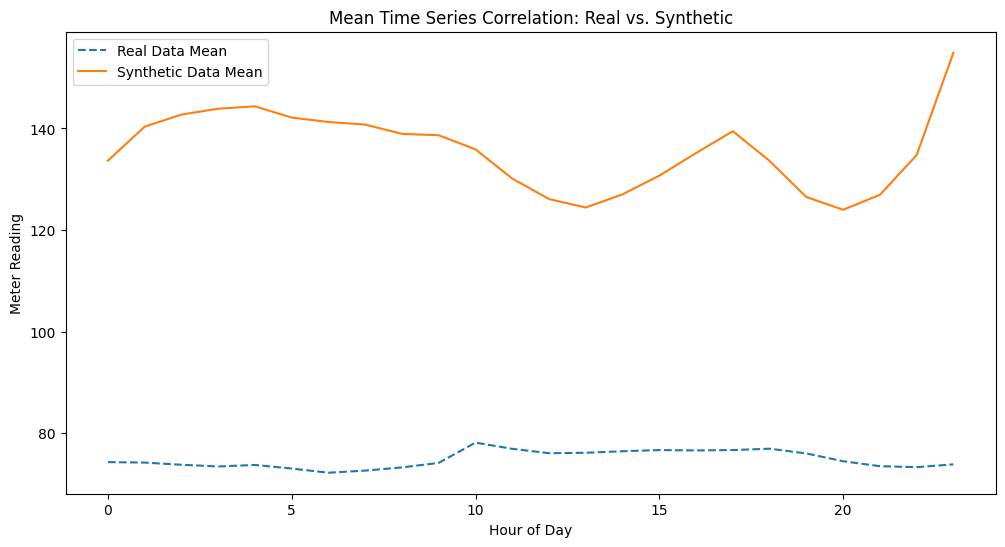

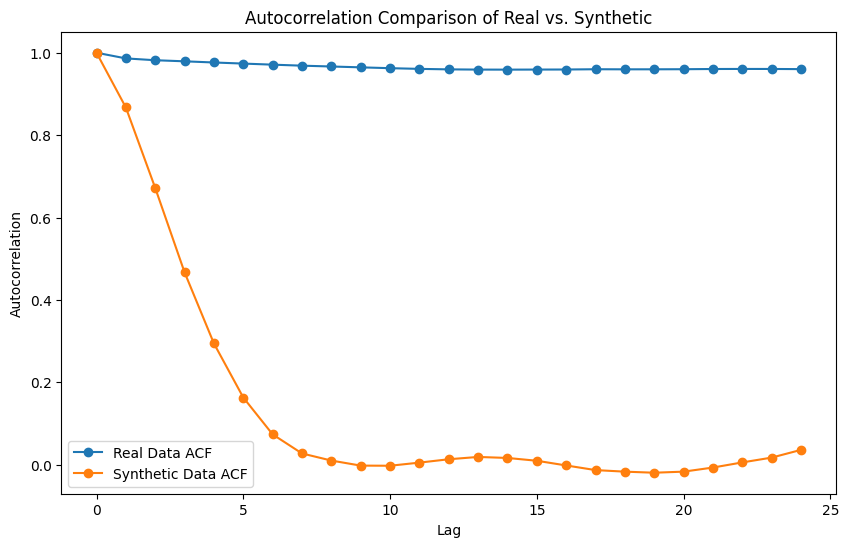

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ks_2samp

# Load real and synthetic data
real_data = pd.read_csv('train.csv')

# Filter real data for building_id = 1 and meter = 0
real_data = real_data[(real_data['building_id'] == 1) & (real_data['meter'] == 0)]

# Extract and normalize real data
real_data['timestamp'] = pd.to_datetime(real_data['timestamp'])
real_data['hour'] = real_data['timestamp'].dt.hour
real_data['day_of_week'] = real_data['timestamp'].dt.dayofweek
real_data['hour_sin'] = np.sin(2 * np.pi * real_data['hour'] / 24)
real_data['hour_cos'] = np.cos(2 * np.pi * real_data['hour'] / 24)
real_data['day_sin'] = np.sin(2 * np.pi * real_data['day_of_week'] / 7)
real_data['day_cos'] = np.cos(2 * np.pi * real_data['day_of_week'] / 7)

# Drop unnecessary columns and normalize
real_data = real_data[['meter_reading', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']]

# Load synthetic data
synthetic_data = pd.read_csv('synthetic_data.csv')

# Reshape synthetic data to match real data format
sequence_length = 24
synthetic_meter_reading = synthetic_data.values.reshape(-1, sequence_length)

# Flatten real data to match synthetic shape for comparison
real_meter_reading = real_data['meter_reading'].values[:synthetic_meter_reading.size].reshape(-1, sequence_length)

# --- 1. Statistical Evaluation ---

# Calculate basic statistics for real and synthetic data
def print_statistics(real, synthetic):
    print("Real Data Statistics:")
    print(f"Mean: {np.mean(real)} | Std: {np.std(real)} | Min: {np.min(real)} | Max: {np.max(real)}\n")
    
    print("Synthetic Data Statistics:")
    print(f"Mean: {np.mean(synthetic)} | Std: {np.std(synthetic)} | Min: {np.min(synthetic)} | Max: {np.max(synthetic)}\n")

print_statistics(real_meter_reading, synthetic_meter_reading)

# KS Test to compare distributions
def perform_ks_test(real, synthetic):
    ks_statistic, p_value = ks_2samp(real.flatten(), synthetic.flatten())
    print(f"KS Test Statistic: {ks_statistic:.4f} | P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject null hypothesis: Real and synthetic data distributions are similar.\n")
    else:
        print("Reject null hypothesis: Real and synthetic data distributions are significantly different.\n")

perform_ks_test(real_meter_reading, synthetic_meter_reading)

# --- 2. Visualization ---

# Plot real vs synthetic data
def plot_data_comparison(real, synthetic, n_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(n_samples):
        plt.plot(real[i], label=f"Real {i+1}", linestyle='--')
        plt.plot(synthetic[i], label=f"Synthetic {i+1}")
    plt.title("Comparison of Real vs. Synthetic Meter Reading Sequences")
    plt.xlabel("Hour")
    plt.ylabel("Meter Reading")
    plt.legend()
    plt.show()

plot_data_comparison(real_meter_reading, synthetic_meter_reading)

# Histogram comparison
def plot_histogram(real, synthetic, bins=50):
    plt.figure(figsize=(10, 6))
    plt.hist(real.flatten(), bins=bins, alpha=0.5, label="Real Data", density=True)
    plt.hist(synthetic.flatten(), bins=bins, alpha=0.5, label="Synthetic Data", density=True)
    plt.title("Histogram Comparison of Real vs. Synthetic Meter Reading")
    plt.xlabel("Meter Reading")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_histogram(real_meter_reading, synthetic_meter_reading)

# --- 3. Predictive Model Comparison ---

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare data for predictive model
real_X, real_y = real_meter_reading[:, :-1], real_meter_reading[:, -1]
synthetic_X, synthetic_y = synthetic_meter_reading[:, :-1], synthetic_meter_reading[:, -1]

# Split real and synthetic data into train-test
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(real_X, real_y, test_size=0.2, random_state=42)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(synthetic_X, synthetic_y, test_size=0.2, random_state=42)

# Train and evaluate a predictive model
def evaluate_model(X_train, X_test, y_train, y_test, data_type="Real"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{data_type} Data Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}\n")

evaluate_model(X_train_real, X_test_real, y_train_real, y_test_real, "Real")
evaluate_model(X_train_syn, X_test_syn, y_train_syn, y_test_syn, "Synthetic")

# --- 4. Time Series Correlation ---

def plot_correlation(real, synthetic):
    real_mean = np.mean(real, axis=0)
    synthetic_mean = np.mean(synthetic, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(real_mean, label="Real Data Mean", linestyle='--')
    plt.plot(synthetic_mean, label="Synthetic Data Mean")
    plt.title("Mean Time Series Correlation: Real vs. Synthetic")
    plt.xlabel("Hour of Day")
    plt.ylabel("Meter Reading")
    plt.legend()
    plt.show()

plot_correlation(real_meter_reading, synthetic_meter_reading)

# --- 5. Autocorrelation Comparison ---
from statsmodels.tsa.stattools import acf

def plot_autocorrelation(real, synthetic, lags=24):
    real_acf = acf(real.flatten(), nlags=lags)
    synthetic_acf = acf(synthetic.flatten(), nlags=lags)

    plt.figure(figsize=(10, 6))
    plt.plot(real_acf, label="Real Data ACF", marker='o')
    plt.plot(synthetic_acf, label="Synthetic Data ACF", marker='o')
    plt.title("Autocorrelation Comparison of Real vs. Synthetic")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.show()

plot_autocorrelation(real_meter_reading, synthetic_meter_reading)